# Denoising Gaussian Markov Random Fields

## Step 1: Setup

We begin by importing the standard python packages numpy and matplotlib.pyplot, as well as networkx for some useful graph and network functions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx
%matplotlib inline

We generate a graph by dropping ```nr_agents``` sensing locations uniformly over the 2-D region $[0, 1]\times[0, 1]$ and subsequently connecting nodes. which are within ```max_distance``` of each other. Weights are set as ```max_distance-distance```, where ```distance``` denotes the Euclidean distance. Finally, run a check to ensure the network is connected, and raise a warning if not.

In [2]:
nr_agents = 1000

locations = np.random.uniform(0, 1, (nr_agents, 2))
max_distance = 0.1

A = np.zeros((nr_agents, nr_agents))

for k in range(nr_agents):
    for l in range(nr_agents):
        distance = np.linalg.norm(locations[k,:]-locations[l,:], 2)
        if distance <= max_distance:
            A[k, l] = max_distance-distance

if not networkx.is_connected(networkx.from_numpy_array(A)):
    print('Careful, your network is not connected. Consider reducing max_distance or increasing nr_agents.')

## Step 2: GMRF Data Generation

We compute the diagonal matrix $D$ consisting of the degrees:

$$D = \mathrm{diag}\{A \mathbb{1}\}$$

as well as the graph Laplacian:

$$L = D - A$$

with eigendecomposition $L = V \Lambda V^{\mathsf{T}}$. We also save a pruned version of $L$ without the leading eigenvalue. It can be shown that for connected graphs, the leading eigenvalue is equal to zero, while all others are strictly positive.

In [3]:
D = np.diag(np.squeeze(A @ np.ones((nr_agents, 1))))
L = D - A
Lambda, V = np.linalg.eigh(L)

Lambda_without_first_eigenvalue = np.diag(Lambda[1:])

Specify the smoothness variance parameter $\eta$. We then generate the GMRF signal in the transformed domain. Specifically, recall the GMRF prior:

$$f\left(\scriptstyle{\mathcal{W}}\right)\, \propto \, e^{- \frac{\eta}{2} \scriptstyle{\mathcal{W}}^{\mathsf{T}} \mathcal{L} \scriptstyle{\mathcal{W}}}$$

Then the prior on the transformed variable $\mathcal{V}^{\mathsf{T}}\scriptstyle{\mathcal{W}}$ diagonalizes:

$$f\left(\mathcal{V}^{\mathsf{T}} \scriptstyle{\mathcal{W}}\right)\, \propto \, e^{- \frac{\eta}{2} \scriptstyle{\mathcal{W}}^{\mathsf{T}} \mathcal{V} \mathcal{L} \mathcal{V}^{\mathsf{T}}\scriptstyle{\mathcal{W}}} = \, e^{- \frac{\eta}{2} \scriptstyle{\mathcal{W}}^{\mathsf{T}} \Lambda \scriptstyle{\mathcal{W}}}$$

We generate all but the first entry of the transformed signal accordingly, and set the first entry (corresponding to the eigenvalue of zero, and eigenvector of all ones), to zero without loss of generality. The actual signal is obtained by transforming back via $\scriptstyle{\mathcal{W}} = \mathcal{V} \mathcal{V}^{\mathsf{T}} \scriptstyle{\mathcal{W}}$. Then plot the signal.

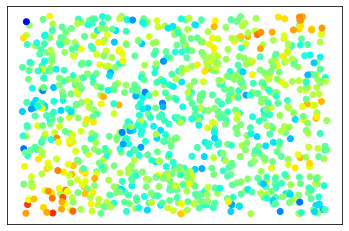

In [4]:
eta = .1

signal_transformed = np.random.multivariate_normal(np.zeros(nr_agents-1), np.linalg.inv(eta*Lambda_without_first_eigenvalue))
signal_transformed_with_mean = np.append(0, signal_transformed)
signal = V @ signal_transformed_with_mean

plt.scatter(locations[:, 0], locations[:, 1], c=signal, cmap='jet')
plt.clim(-20,20)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.show()

# Step 3: Corruption and Smoothing

We now proceed to corrupt and filter the data. Set the ```noise_power``` $\sigma_v^2$ and perturb the signal using i.i.d. noise, then plot.

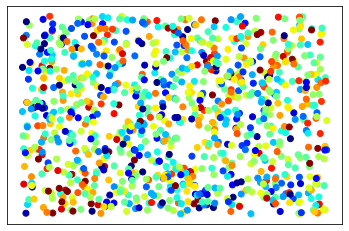

In [5]:
noise_power = 100
signal_observed = signal + np.random.multivariate_normal(np.zeros(nr_agents), noise_power*np.eye(nr_agents))
plt.scatter(locations[:, 0], locations[:, 1], c=signal_observed, cmap='jet')
plt.clim(-20,20)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.show()

We first demonstrate optimal (in the maximum aposteriori sense) recovery through:

$$ \scriptstyle{\mathcal{W}}^o = {\left( I + \eta \sigma_v^2 \mathcal{L} \right)}^{-1} \gamma$$

The result is significant noise reduction at the expense of slight reduction in natural signal variation.

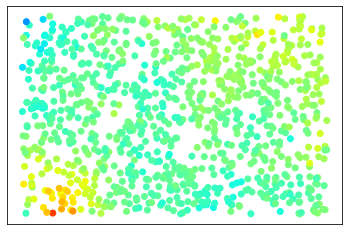

In [6]:
correct_recovered = np.linalg.inv(np.eye(nr_agents) + eta*noise_power*L) @ signal_observed
plt.scatter(locations[:, 0], locations[:, 1], c=correct_recovered, cmap='jet')
plt.clim(-20,20)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.show()

Repeat the recovery where now the signal prior is significantly smoother than the true signal variation, controlled through the parameter $\eta$. We observe a reconstructed signal that is "oversmoothed". We have removed the noise, but also all natural signal variation.

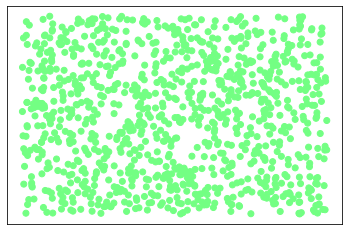

In [7]:
oversmoothed_eta = 1000
oversmoothed_recovered = np.linalg.inv(np.eye(nr_agents) + oversmoothed_eta*noise_power*L) @ signal_observed
plt.scatter(locations[:, 0], locations[:, 1], c=oversmoothed_recovered, cmap='jet')
plt.clim(-20,20)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.show()

Repeat the recovery where now the signal prior is significantly *less* smooth than the true signal variation, controlled through the parameter $\eta$. We have not been able to remove any meaningful noise.

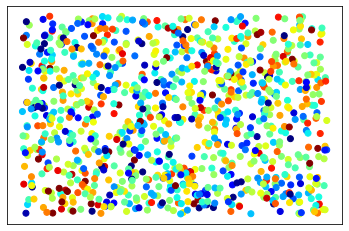

In [8]:
undersmoothed_eta = 0.0001
undersmoothed_recovered = np.linalg.inv(np.eye(nr_agents) + undersmoothed_eta*noise_power*L) @ signal_observed
plt.scatter(locations[:, 0], locations[:, 1], c=undersmoothed_recovered, cmap='jet')
plt.clim(-20,20)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=False)
plt.show()